In [149]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.feature_selection import RFECV, RFE 
from sklearn.pipeline import Pipeline

In [19]:
df = pd.read_csv("Terry_Stops_20250719.csv")
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,47:00.0,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,43:00.0,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,36:00.0,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,25:58.0,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,53:15.0,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2


In [20]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               31621 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

In [22]:
df.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 563
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

- Weapon Type is missing a lot of values and might be relevant to model-building.
- Check its importance before building a model and assess whether imputation or dropping it completely is the right move

In [23]:
missing_percent = df['Weapon Type'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")


Missing: 50.74%


In [24]:
df['Weapon Type Missing'] = df['Weapon Type'].isnull().astype(int)
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


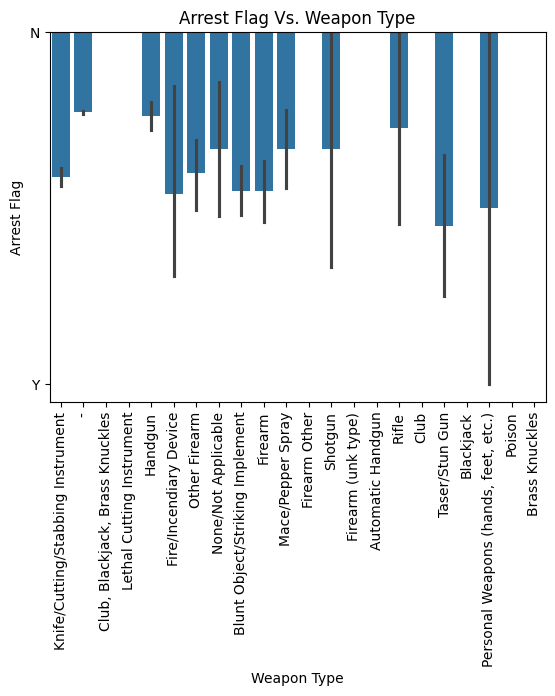

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Weapon Type', y='Arrest Flag', data=df)
plt.title("Arrest Flag Vs. Weapon Type")
plt.xticks(rotation=90)
plt.show()


In [26]:
#Scoring Using Missingness Indicator (1 = missing, 0 = weapon type present)
model_missing_only = RandomForestClassifier(random_state=42)
score_missing_only = cross_val_score(
    model_missing_only,
    df[['Weapon Type Missing']],
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score using only missingness indicator: {score_missing_only:.4f}")


Score using only missingness indicator: 0.8874


In [27]:
# Scoring using actual Weapon Type values 
df_notnull = df.dropna(subset=['Weapon Type'])

# One-hot encode Weapon Type
X_weapon_encoded = pd.get_dummies(df_notnull[['Weapon Type']], drop_first=True)
y_notnull = df_notnull['Arrest Flag']

model_encoded = RandomForestClassifier(random_state=42)
score_encoded = cross_val_score(
    model_encoded,
    X_weapon_encoded,
    y_notnull,
    cv=5
).mean()

print(f"Score using actual Weapon Type values (non-missing): {score_encoded:.4f}")


Score using actual Weapon Type values (non-missing): 0.7712


In [28]:
# Scoring after imputing and encoding Weapon Type
df['Weapon_Type_filled'] = df['Weapon Type'].fillna('Unknown')
X_full_encoded = pd.get_dummies(df[['Weapon_Type_filled']], drop_first=True)

model_imputed = RandomForestClassifier(random_state=42)
score_imputed = cross_val_score(
    model_imputed,
    X_full_encoded,
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score after imputing and encoding Weapon Type: {score_imputed:.4f}")


Score after imputing and encoding Weapon Type: 0.8870


### Model Comparison Results
| Model Version                                  | CV Score   | Interpretation                                                            |
| ---------------------------------------------- | ---------- | ------------------------------------------------------------------------- |
|  **Missingness indicator only**               | **0.8874** | Highest score — strong signal just from whether the value is missing.     |
|  **Actual Weapon Type values** (no missing) | 0.7712     | Much lower — actual values are *less predictive* than missingness itself. |
|  **Imputed + Encoded Weapon Type**            | 0.8870     | Almost same as missingness only — imputation doesn't add useful signal.   |  

- Missingness > Actual Data:

    - The fact that Weapon Type is missing tells the model more about arrest likelihood than the actual weapon type does.

    - Possibly: unreported weapon types are correlated with non-arrests.

- Imputing Doesn’t Improve the Model

- Best Option for Modeling:

    - Keep the missingness indicator as a feature "Weapon_Type_missing" and drop the "Weapon Type" column


In [29]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing,Weapon_Type_filled
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1,Unknown
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1,Unknown
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1,Unknown
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0,Knife/Cutting/Stabbing Instrument
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0,-
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1,Unknown
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1,Unknown
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0,-


In [30]:
features = [..., 'Weapon Type Missing']  # include it
df.drop(columns=['Weapon Type', 'Weapon_Type_filled'], inplace=True)  #drop

In [31]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


In [32]:
df.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               563
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
Weapon Type Missing           0
dtype: int64

In [33]:
#Officer Squad column has 563 missing values, impute using mode because its categorical
df["Officer Squad"].mode()

0    TRAINING - FIELD TRAINING SQUAD
Name: Officer Squad, dtype: object

In [34]:
impute_value = df["Officer Squad"].mode()[0]
df.fillna({"Officer Squad": impute_value}, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Officer ID                64186 non-null  object 
 6   Officer YOB               64186 non-null  int64  
 7   Officer Gender            64186 non-null  object 
 8   Officer Race              64186 non-null  object 
 9   Subject Perceived Race    64186 non-null  object 
 10  Subject Perceived Gender  64186 non-null  object 
 11  Reported Date             64186 non-null  object 
 12  Reported Time             64186 non-null  object 
 13  Initial Call Type         64186 non-null  object 
 14  Final 

In [36]:
df.drop_duplicates(subset= ["Terry Stop ID"])

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


In [37]:
df["Subject Age Group"].value_counts()

Subject Age Group
26 - 35         21406
36 - 45         14543
18 - 25         12012
46 - 55          8110
56 and Above     3392
Jan-17           2369
-                2354
Name: count, dtype: int64

In [38]:
df[df['Subject Age Group'] == 'Jan-17'].head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
8,Jan-17,-1,2.020000e+13,171129,Arrest,8365,1984,Female,White,Black or African American,...,THEFT OF SERVICES,THEFT - ALL OTHER,911,TRAINING - FIELD TRAINING SQUAD,N,N,East,E,E2,1
80,Jan-17,-1,2.020000e+13,274320,Offense Report,8362,1987,Male,Two or More Races,Black or African American,...,ROBBERY - CRITICAL (INCLUDES STRONG ARM),ROBBERY - STRONG ARM,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L2,1
138,Jan-17,-1,2.020000e+13,526365,Offense Report,8490,1989,Male,White,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,SOUTH PCT 2ND W - OCEAN - PLATOON 2,N,Y,South,O,O3,1
159,Jan-17,7738294742,2.020000e+13,49251617503,Field Contact,8881,1988,Male,Asian,Black or African American,...,DISTURBANCE - DV CRITICAL,"DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,NORTH PCT 2ND W - UNION - PLATOON 2,N,Y,North,U,U3,0


## Formatting the Age Column

In [39]:
# Replace "-" with NaN (
df['Subject Age Group'] = df['Subject Age Group'].replace('-', np.nan) 

In [40]:
# #Impute Nan values with most occurring age group
age_impute = df["Subject Age Group"].mode()[0]
df.fillna({"Subject Age Group": age_impute}, inplace = True)

In [41]:
# #Excel may have misinterpreted age bracket 1-17 to mean a date-time format, replace with 1-17
df['Subject Age Group'] = df['Subject Age Group'].replace('Jan-17', '1-17')

In [42]:
print(df["Subject Age Group"].unique())

['46 - 55' '18 - 25' '26 - 35' '36 - 45' '1-17' '56 and Above']


In [43]:
# #Mapping age group categories to integers using ordinal encoding to preserve hierarchy
df["Subject Age Group"] = df["Subject Age Group"].str.strip().str.lower() # Strip whitespace and standardize casing

# Update the mapping to match the cleaned values
age_mapping = {
    '1-17': 0,
    '18 - 25': 1,
    '26 - 35': 2,
    '36 - 45': 3,
    '46 - 55': 4,
    '56 and above': 5,
}

# Apply mapping
df['Subject Age Group'] = df['Subject Age Group'].map(age_mapping)


In [44]:
df['Subject Age Group'].value_counts()

Subject Age Group
2    23760
3    14543
1    12012
4     8110
5     3392
0     2369
Name: count, dtype: int64

## Formatting the Subject ID column

In [45]:
df["Subject ID"].value_counts()

Subject ID
-1              35214
 7753260438        29
 7726918259        22
 21375848115       22
 7774286580        22
                ...  
 34296897289        1
 7726972952         1
 7725634574         1
 7742172289         1
 53986235598        1
Name: count, Length: 18659, dtype: int64

In [46]:
#To captures meaningful behavioral signal such as:
    # Whether a subject identifies themselves (or not) might correlate with:
    # The likelihood of arrest (e.g., police may be more suspicious of those who refuse ID)
    # Age group or demographics (e.g., minors may be more likely to go unidentified)
#map availability of subject ID, where -1 represents anonymity or unprovided ID

df["Subject Identified"] = df["Subject ID"].apply(lambda x: 0 if x == -1 else 1)

In [47]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing,Subject Identified
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1,0
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1,0
2,2,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1,0
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0,1
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0,1
64182,2,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1,0
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1,0
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0,1


**Rows with low predictive power = GO / SC Num, Terry Stop ID, Officer ID**

In [48]:
df["Stop Resolution"].value_counts()

Stop Resolution
Field Contact               31833
Offense Report              15962
Arrest                      15438
Referred for Prosecution      728
Citation / Infraction         225
Name: count, dtype: int64

One hot encode this column. Mapping, such as 0,1,2, would imply an inherent order where there in none

## Dealing with Year of Birth

In [49]:
df["Officer YOB"].value_counts()

Officer YOB
1986    4122
1987    3917
1991    3559
1992    3504
1990    3296
1984    3214
1989    3208
1985    2952
1988    2684
1995    2608
1993    2453
1982    2093
1983    2037
1979    1939
1994    1874
1981    1761
1996    1536
1976    1502
1971    1327
1978    1297
1997    1273
1977    1185
1973    1114
1980    1017
1967     852
1970     746
1968     701
1975     664
1969     634
1974     608
1972     493
1998     485
1964     476
1962     465
1965     424
1963     265
1961     263
1966     252
1958     223
1999     221
1959     174
1960     161
2000     151
1900     109
2001      94
2002      57
1954      44
1957      43
1953      41
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
2003       2
1951       1
Name: count, dtype: int64

In [50]:
#Calculating the median Year of Birth (ignoring missing or invalid values)
valid_yobs = df[(df['Officer YOB'] >= 1955) & (df['Officer YOB'] <= 2005)]
median_yob = valid_yobs['Officer YOB'].median()

#Replacing unrealistic YOBs (e.g., before 1955 or after 2005) with the median
df.loc[(df['Officer YOB'] < 1955) | (df['Officer YOB'] > 2005), 'Officer YOB'] = median_yob

df["Officer YOB"].value_counts()

Officer YOB
1986    4344
1987    3917
1991    3559
1992    3504
1990    3296
1984    3214
1989    3208
1985    2952
1988    2684
1995    2608
1993    2453
1982    2093
1983    2037
1979    1939
1994    1874
1981    1761
1996    1536
1976    1502
1971    1327
1978    1297
1997    1273
1977    1185
1973    1114
1980    1017
1967     852
1970     746
1968     701
1975     664
1969     634
1974     608
1972     493
1998     485
1964     476
1962     465
1965     424
1963     265
1961     263
1966     252
1958     223
1999     221
1959     174
1960     161
2000     151
2001      94
2002      57
1957      43
1955      21
1956      17
2003       2
Name: count, dtype: int64

## Race and Gender

In [51]:
df[['Officer Gender', 'Officer Race']].value_counts()

Officer Gender  Officer Race                             
Male            White                                        40071
Female          White                                         5465
Male            Hispanic                                      3915
                Two or More Races                             3634
                Asian                                         3123
                Declined to Answer                            2829
                Black or African American                     2415
Female          Two or More Races                              994
Male            Native Hawaiian or Other Pacific Islander      556
Female          Hispanic                                       345
Male            American Indian or Alaska Native               242
Female          Declined to Answer                             181
                Black or African American                      156
                Asian                                          136
Male

In [52]:
cols = ['Subject Perceived Gender', 'Subject Perceived Race', 'Officer Gender', 'Officer Race']  

for col in cols:
    print(f"\nValue counts for {col}:\n")
    print(df[col].value_counts(dropna=False))  # `dropna=False` includes missing values in the count



Value counts for Subject Perceived Gender:

Subject Perceived Gender
Male                                                         50668
Female                                                       12763
Unable to Determine                                            326
-                                                              249
Unknown                                                        114
Gender Diverse (gender non-conforming and/or transgender)       65
MULTIPLE SUBJECTS                                                1
Name: count, dtype: int64

Value counts for Subject Perceived Race:

Subject Perceived Race
White                                        31415
Black or African American                    19316
Unknown                                       4861
Asian                                         2209
-                                             1822
American Indian or Alaska Native              1738
Hispanic                                      1684
Multi-Racial

In [53]:
# Getting the mode value(most common value)
gender_mode = df["Subject Perceived Gender"].mode()[0]
race_mode = df["Subject Perceived Race"].mode()[0]

#Replacing "-" with the mode in each column
df["Subject Perceived Gender"] = df["Subject Perceived Gender"].replace("-", gender_mode)
df["Subject Perceived Race"] = df["Subject Perceived Race"].replace("-", race_mode)

In [54]:
#Subject data wrangling
#Group ambiguous gender values
df["Subject Perceived Gender"] = df["Subject Perceived Gender"].replace(
    ["Unknown", "Unable to Determine", "MULTIPLE SUBJECTS"],
    "Unknown"
)

# Group ambiguous race values
df["Subject Perceived Race"] = df["Subject Perceived Race"].replace(
    ["Unknown", "MULTIPLE SUBJECTS", "Other"],
    "Unknown"
)

#Officer data wrangling
df["Officer Gender"] = df["Officer Gender"].replace("Non-Specified", "Unknown")

df["Officer Race"] = df["Officer Race"].replace("Declined to Answer", "Unknown")


In [55]:
cols = ['Subject Perceived Gender', 'Subject Perceived Race', 'Officer Gender', 'Officer Race']  

for col in cols:
    print(f"\nValue counts for {col}:\n")
    print(df[col].value_counts(dropna=False))  



Value counts for Subject Perceived Gender:

Subject Perceived Gender
Male                                                         50917
Female                                                       12763
Unknown                                                        441
Gender Diverse (gender non-conforming and/or transgender)       65
Name: count, dtype: int64

Value counts for Subject Perceived Race:

Subject Perceived Race
White                                        33237
Black or African American                    19316
Unknown                                       5014
Asian                                         2209
American Indian or Alaska Native              1738
Hispanic                                      1684
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander      179
Name: count, dtype: int64

Value counts for Officer Gender:

Officer Gender
Male       56864
Female      7292
Unknown       30
Name: count, dtype: int64

Value co

## Reported Date and Time

In [56]:
cols = ['Reported Date', 'Reported Time']  

for col in cols:
    print(f"\nValue counts for {col}:\n")
    print(df[col].value_counts(dropna=False))  


Value counts for Reported Date:

Reported Date
2015-10-01T00:00:00Z    101
2015-09-29T00:00:00Z     66
2015-05-28T00:00:00Z     57
2015-07-18T00:00:00Z     55
2019-04-26T00:00:00Z     54
                       ... 
2015-05-13T00:00:00Z      1
2024-06-29T00:00:00Z      1
2015-03-15T00:00:00Z      1
2025-07-14T00:00:00Z      1
2025-04-27T00:00:00Z      1
Name: count, Length: 3778, dtype: int64

Value counts for Reported Time:

Reported Time
00:00.0    719
30:00.0    666
25:00.0    625
15:00.0    617
47:00.0    616
          ... 
02:08.0      1
41:49.0      1
30:33.0      1
59:32.0      1
28:01.0      1
Name: count, Length: 3599, dtype: int64


In [57]:
df["Reported Date"] = pd.to_datetime(df["Reported Date"])  # Convert to datetime

#Extracting:
df["Year"] = df["Reported Date"].dt.year
df["Month"] = df["Reported Date"].dt.month
df["Weekday"] = df["Reported Date"].dt.dayofweek  # 0=Monday, 6=Sunday
df["Day"] = df["Reported Date"].dt.day

"""
These new columns will help in:
1. Detecting seasonal patterns
2. Analyzing weekend vs weekday trends
3. Using year to see trends over time 
"""

'\nThese new columns will help in:\n1. Detecting seasonal patterns\n2. Analyzing weekend vs weekday trends\n3. Using year to see trends over time \n'

In [58]:
#Identifying invalid time stamps
invalid_times = df[~df["Reported Time"].str.match(r"^([01]\d|2[0-3]):[0-5]\d(\.\d+)?$")]
invalid_times

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing,Subject Identified,Year,Month,Weekday,Day
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,N,West,Q,Q2,1,0,2018,7,0,30
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,Y,North,J,J1,1,0,2018,7,0,23
2,2,-1,2.020000e+13,234548,Offense Report,4852,1986,Male,Asian,White,...,N,North,L,L3,1,0,2017,1,0,30
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,Y,West,K,K3,0,1,2023,5,1,2
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,N,South,R,R2,0,1,2023,3,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64177,4,7726955869,2.020000e+13,17806244576,Offense Report,8763,1997,Female,White,White,...,Y,South,R,R1,0,1,2020,11,3,19
64180,5,10518370784,2.020000e+13,19739908341,Field Contact,8776,1992,Male,Two or More Races,White,...,N,West,Q,Q3,0,1,2021,1,5,16
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,Y,North,L,L2,1,0,2017,11,3,23
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Unknown,White,...,N,East,E,E2,0,1,2024,7,1,23


In [59]:
#Marking invalid times as NaN
df["Reported Time"] = df["Reported Time"].where(df["Reported Time"].str.match(r"^([01]\d|2[0-3]):[0-5]\d(\.\d+)?$"))

#Removing the ".0" part if present
df["Clean Time"] = df["Reported Time"].str.replace(r"\.0$", "", regex=True)

#Conversion and extraction
df["Hour"] = pd.to_datetime(df["Clean Time"], format="%H:%M", errors="coerce").dt.hour
df["Minute"] = pd.to_datetime(df["Clean Time"], format="%H:%M", errors="coerce").dt.minute


In [60]:
df.isna().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time               38293
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                   0
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
Weapon Type Missing             0
Subject Identified              0
Year                            0
Month                           0
Weekday                         0
Day                             0
Clean Time                  38293
Hour          

In [61]:
missing_percent = df['Reported Time'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")


Missing: 59.66%


In [62]:
df["Initial Call Type"].value_counts()

Initial Call Type
-                                             13584
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW     5229
SUSPICIOUS PERSON, VEHICLE, OR INCIDENT        4481
DISTURBANCE                                    3281
ASLT - CRITICAL (NO SHOOTINGS)                 2800
                                              ...  
ESCAPE - PRISONER                                 1
INFORMATIONAL BROADCASTS                          1
ALARM - ATM MACHINE, FREE STANDING                1
ASSIGNED DUTY - STAKEOUT                          1
PROPERTY - FOUND GUN, SHELLCASINGS                1
Name: count, Length: 186, dtype: int64

In [63]:
df["Final Call Type"].value_counts()

Final Call Type
-                                                  13584
SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON              6069
PROWLER - TRESPASS                                  4532
DISTURBANCE - OTHER                                 3836
ASSAULTS, OTHER                                     3203
                                                   ...  
OFF DUTY EMPLOYMENT                                    1
PEDESTRIAN VIOLATIONS                                  1
DISTURBANCE - DV - NO ASLT                             1
ALARM-VEHICLE ALARMS                                   1
COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)        1
Name: count, Length: 201, dtype: int64

In [64]:
# Replace missing
df["Initial Call Type"] = df["Initial Call Type"].replace("-", "Unknown")
df["Final Call Type"] = df["Final Call Type"].replace("-", "Unknown")

# Group rare values
top_initial = df["Initial Call Type"].value_counts().nlargest(15).index
df["Initial Call Type"] = df["Initial Call Type"].apply(lambda x: x if x in top_initial else "Other")

top_final = df["Final Call Type"].value_counts().nlargest(15).index
df["Final Call Type"] = df["Final Call Type"].apply(lambda x: x if x in top_final else "Other")


## Call Type

In [65]:
df["Call Type"].value_counts()

Call Type
911                              30299
ONVIEW                           15447
-                                13584
TELEPHONE OTHER, NOT 911          4287
ALARM CALL (NOT POLICE ALARM)      537
TEXT MESSAGE                        30
SCHEDULED EVENT (RECURRING)          1
HISTORY CALL (RETRO)                 1
Name: count, dtype: int64

In [66]:
# Replace missing with 'Unknown'
df["Call Type"] = df["Call Type"].replace("-", "Unknown")

# Define top/keep categories
top_call_types = ["911", "ONVIEW", "TELEPHONE OTHER, NOT 911", "ALARM CALL (NOT POLICE ALARM)", "Unknown"]

# Group others into "Other"
df["Call Type"] = df["Call Type"].apply(lambda x: x if x in top_call_types else "Other")


In [67]:
df["Call Type"].value_counts()

Call Type
911                              30299
ONVIEW                           15447
Unknown                          13584
TELEPHONE OTHER, NOT 911          4287
ALARM CALL (NOT POLICE ALARM)      537
Other                               32
Name: count, dtype: int64

## Officer Squad

In [68]:
df["Officer Squad"].value_counts()

Officer Squad
TRAINING - FIELD TRAINING SQUAD            7465
WEST PCT 1ST W - DAVID - PLATOON 1         1706
WEST PCT 3RD W - KING - PLATOON 1          1519
WEST PCT 1ST W - KING - PLATOON 1          1359
SOUTHWEST PCT 2ND W - FRANK - PLATOON 2    1295
                                           ... 
SOUTH PCT 2ND W - ROBERT                      1
HUMAN TRAFFICKING - SQUAD A                   1
NORTH PCT 1ST W - NORA (JOHN)                 1
WEST PCT OPS - ACT NIGHT                      1
TRAINING - LEARNING MANAGEMENT SYSTEM         1
Name: count, Length: 278, dtype: int64

In [69]:
# Replace NaN with 'Unknown' if any
df["Officer Squad"] = df["Officer Squad"].fillna("Unknown")

# Get top 10 most common squads
top_squads = df["Officer Squad"].value_counts().nlargest(10).index

# Replace less frequent squads with 'Other'
df["Officer Squad"] = df["Officer Squad"].apply(lambda x: x if x in top_squads else "Other")


In [70]:
df["Frisk Flag"].value_counts()

Frisk Flag
N    48138
Y    15570
-      478
Name: count, dtype: int64

In [71]:
# Replace missing with 'Unknown'
df["Frisk Flag"] = df["Frisk Flag"].replace("-", "Unknown")

In [72]:
df["Frisk Flag"].value_counts()

Frisk Flag
N          48138
Y          15570
Unknown      478
Name: count, dtype: int64

In [73]:
df["Arrest Flag"].value_counts()

Arrest Flag
N    56956
Y     7230
Name: count, dtype: int64

In [ ]:
#Mapping Arrest and Frisk flags
df["Frisk Flag"] = df["Frisk Flag"].map({"N": 0, "Y": 1})
df["Arrest Flag"] = df["Arrest Flag"].map({"N": 0, "Y": 1})
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Beat,Weapon Type Missing,Subject Identified,Year,Month,Weekday,Day,Clean Time,Hour,Minute
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,Q2,1,0,2018,7,0,30,NaN,NaN,NaN
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,J1,1,0,2018,7,0,23,NaN,NaN,NaN
2,2,-1,2.020000e+13,234548,Offense Report,4852,1986,Male,Asian,White,...,L3,1,0,2017,1,0,30,NaN,NaN,NaN
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,K3,0,1,2023,5,1,2,NaN,NaN,NaN
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,R2,0,1,2023,3,4,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,F1,0,1,2021,1,6,10,15:57,15.0,57.0
64182,2,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,B2,1,0,2016,10,2,5,06:00,6.0,0.0
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,L2,1,0,2017,11,3,23,NaN,NaN,NaN
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Unknown,White,...,E2,0,1,2024,7,1,23,NaN,NaN,NaN


## Precinct, Sector, and Beat

In [75]:
# Columns to inspect
location_cols = ['Precinct', 'Sector', 'Beat']

for col in location_cols:
    print(f"\n--- {col} ---")
    print(f"Unique values: {df[col].nunique()}")
    print("Top 10 most frequent values:")
    print(df[col].value_counts().head(10))



--- Precinct ---
Unique values: 9
Top 10 most frequent values:
Precinct
West         18173
North        13385
-            10785
East          8798
South         7754
Southwest     4952
Unknown        200
OOJ            117
FK ERROR        22
Name: count, dtype: int64

--- Sector ---
Unique values: 20
Top 10 most frequent values:
Sector
-    10936
K     6353
M     5491
E     4645
N     3816
D     3618
R     2985
F     2952
B     2834
Q     2707
Name: count, dtype: int64

--- Beat ---
Unique values: 55
Top 10 most frequent values:
Beat
-     10930
K3     3805
M3     2723
E2     1927
N3     1923
E1     1569
D1     1439
R2     1429
N2     1427
M2     1398
Name: count, dtype: int64


In [76]:
df["Precinct"] = df["Precinct"].replace(["-", "Unknown", "OOJ", "FK ERROR"], "Unknown")

df["Sector"] = df["Sector"].replace("-", "Unknown")


In [77]:
df["Precinct"] = df["Precinct"].str.title()
df["Sector"] = df["Sector"].str.upper()

In [78]:
print(df["Precinct"].value_counts())
print(df["Sector"].value_counts())


Precinct
West         18173
North        13385
Unknown      11124
East          8798
South         7754
Southwest     4952
Name: count, dtype: int64
Sector
UNKNOWN    10936
K           6353
M           5491
E           4645
N           3816
D           3618
R           2985
F           2952
B           2834
Q           2707
L           2594
O           2424
U           2348
S           2344
G           2263
W           1996
C           1890
J           1791
99           137
OOJ           62
Name: count, dtype: int64


In [79]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Beat,Weapon Type Missing,Subject Identified,Year,Month,Weekday,Day,Clean Time,Hour,Minute
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,Q2,1,0,2018,7,0,30,NaN,NaN,NaN
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,J1,1,0,2018,7,0,23,NaN,NaN,NaN
2,2,-1,2.020000e+13,234548,Offense Report,4852,1986,Male,Asian,White,...,L3,1,0,2017,1,0,30,NaN,NaN,NaN
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,K3,0,1,2023,5,1,2,NaN,NaN,NaN
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,R2,0,1,2023,3,4,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,F1,0,1,2021,1,6,10,15:57,15.0,57.0
64182,2,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,B2,1,0,2016,10,2,5,06:00,6.0,0.0
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,L2,1,0,2017,11,3,23,NaN,NaN,NaN
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Unknown,White,...,E2,0,1,2024,7,1,23,NaN,NaN,NaN


In [80]:
df = df.drop(columns=["Subject ID", "GO / SC Num", "Terry Stop ID", "Officer ID", "Reported Time", "Clean Time", "Hour", "Minute", "Sector", 
                      "Beat", "Reported Date"])

In [81]:
df

,Subject Age Group,Stop Resolution,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Weapon Type Missing,Subject Identified,Year,Month,Weekday,Day
0,4,Field Contact,1993,Female,Hispanic,White,Male,Unknown,Unknown,Unknown,Other,0,0.0,West,1,0,2018,7,0,30
1,1,Offense Report,1986,Female,White,Black or African American,Male,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...",Other,911,TRAINING - FIELD TRAINING SQUAD,0,1.0,North,1,0,2018,7,0,23
2,2,Offense Report,1986,Male,Asian,White,Male,DISTURBANCE,THEFT - SHOPLIFT,911,Other,0,0.0,North,1,0,2017,1,0,30
3,3,Field Contact,1984,Male,White,Native Hawaiian or Other Pacific Islander,Male,Other,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,Other,0,1.0,West,0,1,2023,5,1,2
4,0,Field Contact,1992,Male,Two or More Races,Black or African American,Male,Other,Other,911,Other,0,0.0,South,0,1,2023,3,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,Field Contact,1992,Male,Asian,American Indian or Alaska Native,Female,Other,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,0,0.0,Southwest,0,1,2021,1,6,10
64182,2,Arrest,1984,Male,Two or More Races,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,Other,0,1.0,North,1,0,2016,10,2,5
64183,2,Arrest,1987,Male,Asian,Unknown,Male,Other,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,0,1.0,North,1,0,2017,11,3,23
64184,3,Field Contact,1995,Male,Unknown,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,Other,0,0.0,East,0,1,2024,7,1,23


In [82]:
# Save the wrangled dataset as a CSV file
output_file = "filtered_dataset.csv"
df.to_csv(output_file, index=False)
print(f"New dataset saved as {output_file}")

New dataset saved as filtered_dataset.csv


In [83]:
df = pd.read_csv("filtered_dataset.csv")
df.head()

,Subject Age Group,Stop Resolution,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Weapon Type Missing,Subject Identified,Year,Month,Weekday,Day
0,4,Field Contact,1993,Female,Hispanic,White,Male,Unknown,Unknown,Unknown,Other,0,0.0,West,1,0,2018,7,0,30
1,1,Offense Report,1986,Female,White,Black or African American,Male,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...",Other,911,TRAINING - FIELD TRAINING SQUAD,0,1.0,North,1,0,2018,7,0,23
2,2,Offense Report,1986,Male,Asian,White,Male,DISTURBANCE,THEFT - SHOPLIFT,911,Other,0,0.0,North,1,0,2017,1,0,30
3,3,Field Contact,1984,Male,White,Native Hawaiian or Other Pacific Islander,Male,Other,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,Other,0,1.0,West,0,1,2023,5,1,2
4,0,Field Contact,1992,Male,Two or More Races,Black or African American,Male,Other,Other,911,Other,0,0.0,South,0,1,2023,3,4,31


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  int64  
 1   Stop Resolution           64186 non-null  object 
 2   Officer YOB               64186 non-null  int64  
 3   Officer Gender            64186 non-null  object 
 4   Officer Race              64186 non-null  object 
 5   Subject Perceived Race    64186 non-null  object 
 6   Subject Perceived Gender  64186 non-null  object 
 7   Initial Call Type         64186 non-null  object 
 8   Final Call Type           64186 non-null  object 
 9   Call Type                 64186 non-null  object 
 10  Officer Squad             64186 non-null  object 
 11  Arrest Flag               64186 non-null  int64  
 12  Frisk Flag                63708 non-null  float64
 13  Precinct                  64186 non-null  object 
 14  Weapon

In [85]:
#Running a chi-square test
categorical_cols = [
    'Subject Age Group', 'Stop Resolution', 'Officer Gender', 'Officer Race',
    'Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type',
    'Final Call Type', 'Call Type', 'Officer Squad', 'Precinct',
    'Subject Identified', 'Weapon Type Missing', 'Month', 'Weekday'
]

#Convert to 'category' dtype
df[categorical_cols] = df[categorical_cols].astype('category')


In [86]:
#Performing the test
from scipy.stats import chi2_contingency

def chi_square_test(df, target_col, cat_col):
    contingency_table = pd.crosstab(df[cat_col], df[target_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p


In [87]:
chi2_results = {}

for cat in categorical_cols:
    try:
        chi2_stat, p_val = chi_square_test(df, 'Arrest Flag', cat)
        chi2_results[cat] = {'Chi2 Statistic': chi2_stat, 'p-value': p_val}
    except Exception as e:
        chi2_results[cat] = {'Chi2 Statistic': None, 'p-value': None, 'error': str(e)}

# View as DataFrame
chi2_df = pd.DataFrame(chi2_results).T.sort_values(by='Chi2 Statistic', ascending=False)
chi2_df

,Chi2 Statistic,p-value
Stop Resolution,25709.248667,0.000000e+00
Subject Identified,9900.713994,0.000000e+00
Weapon Type Missing,8388.729808,0.000000e+00
Final Call Type,6948.846649,0.000000e+00
Initial Call Type,2598.459283,0.000000e+00
Call Type,1900.067632,0.000000e+00
Precinct,1116.951868,2.851150e-239
Subject Perceived Race,444.926791,5.455455e-92
Officer Race,251.957560,1.061484e-50
Officer Squad,248.143545,1.333239e-47


In [88]:
#viewing significant predictors
significant = chi2_df[chi2_df['p-value'] < 0.05]
significant

,Chi2 Statistic,p-value
Stop Resolution,25709.248667,0.000000e+00
Subject Identified,9900.713994,0.000000e+00
Weapon Type Missing,8388.729808,0.000000e+00
Final Call Type,6948.846649,0.000000e+00
Initial Call Type,2598.459283,0.000000e+00
Call Type,1900.067632,0.000000e+00
Precinct,1116.951868,2.851150e-239
Subject Perceived Race,444.926791,5.455455e-92
Officer Race,251.957560,1.061484e-50
Officer Squad,248.143545,1.333239e-47


In [89]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V with bias correction
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Store results
results = []

for cat in categorical_cols:
    try:
        table = pd.crosstab(df[cat], df['Arrest Flag'])
        chi2, p, _, _ = chi2_contingency(table)
        v = cramers_v(table)
        results.append({
            'Feature': cat,
            'Chi2 p-value': round(p, 4),
            'Cramér\'s V': round(v, 4)
        })
    except Exception as e:
        results.append({
            'Feature': cat,
            'Chi2 p-value': None,
            'Cramér\'s V': None
        })

# Convert to DataFrame
assoc_df = pd.DataFrame(results).sort_values(by="Cramér's V", ascending=False).reset_index(drop=True)


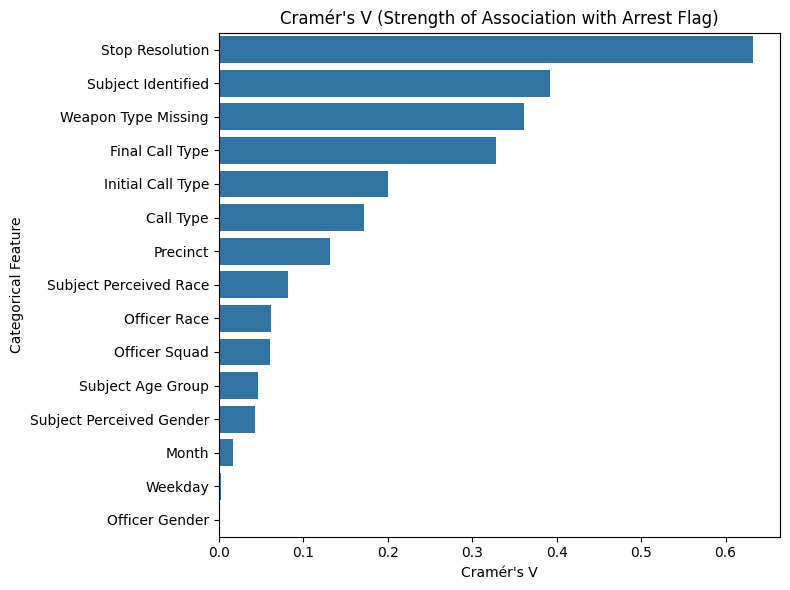

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(data=assoc_df, y='Feature', x="Cramér's V")
plt.title("Cramér's V (Strength of Association with Arrest Flag)")
plt.xlabel("Cramér's V")
plt.ylabel("Categorical Feature")
plt.tight_layout()
plt.show()


Stop resolution is highly correlated with Arrest Flag

In [91]:
# Automatically selects only numerical columns (excluding object, category, etc.)
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Optionally remove the target to just focus on predictors
numerical_cols = [col for col in numerical_cols if col != 'Arrest Flag']


In [92]:
# Compute Pearson correlation with Arrest Flag
correlations = df[numerical_cols + ['Arrest Flag']].corr()['Arrest Flag'].drop('Arrest Flag')

# Sort and visualize
correlations = correlations.sort_values(ascending=False)

print(correlations)


Year           0.288628
Officer YOB    0.144668
Frisk Flag     0.107790
Day            0.005643
Name: Arrest Flag, dtype: float64


In [93]:
target = 'Arrest Flag'
print(df.shape)
print(df[target].value_counts(normalize=True))

(64186, 20)
Arrest Flag
0    0.887359
1    0.112641
Name: proportion, dtype: float64


In [94]:
# Categorical variables to one-hot encode
categorical_predictors = [
    'Stop Resolution', 'Officer Gender', 'Officer Race',
    'Subject Perceived Race', 'Subject Perceived Gender',
    'Initial Call Type', 'Final Call Type', 'Call Type',
    'Officer Squad', 'Precinct', 'Day'  
]

# Numeric predictors to keep as-is
keep_as_is = [
    'Officer YOB',            # Year of birth — continuous
    'Frisk Flag',             # Binary flag
    'Weapon Type Missing',    # Binary flag
    'Subject Identified',     # Binary flag
    'Year',                   # Treated as numeric year
    'Subject Age Group'       # Ordinal-encoded
]

# Features to encode cyclically (for periodic patterns)
cyclical_encode = ['Month', 'Weekday']


In [96]:
#Applying cyclical encoding to the dates
df['Month'] = df['Month'].astype(int)
df['Weekday'] = df['Weekday'].astype(int)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / df['Month'].max())
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / df['Month'].max())
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / df['Weekday'].max())
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / df['Weekday'].max())


In [97]:
X = df[categorical_predictors + keep_as_is + ['Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos']]
y = df['Arrest Flag']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_predictors, drop_first=True)

# Handle missing values (only for binary flags)
X_encoded.fillna({'Frisk Flag': 0}, inplace=True)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [99]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", model.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
[[11392     0]
 [    0  1446]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11392
           1       1.00      1.00      1.00      1446

    accuracy                           1.00     12838
   macro avg       1.00      1.00      1.00     12838
weighted avg       1.00      1.00      1.00     12838



The model has high variance i.e overfitting especially with an accuracy of 1.0. 
Ways to address:
- Reduce number of features
- Increase regularization
- More training data

In [ ]:
#ascertaining target variable is not in predictors
'Arrest Flag' in X.columns

False

In [ ]:
#numeric values correlation
print(df[keep_as_is + ['Arrest Flag']].corr()['Arrest Flag'].sort_values(ascending=False))

Arrest Flag            1.000000
Subject Identified     0.392797
Year                   0.288628
Officer YOB            0.144668
Frisk Flag             0.107790
Subject Age Group      0.032287
Weapon Type Missing   -0.361566
Name: Arrest Flag, dtype: float64


In [102]:
coeffs = pd.Series(model.coef_[0], index=X_train.columns)
print(coeffs.sort_values(ascending=False).head(10))
print(coeffs.sort_values(ascending=True).head(10))


Subject Identified                                            9.218663
Final Call Type_DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY)    0.740034
Final Call Type_WARRANT SERVICES - FELONY                     0.671923
Final Call Type_WARRANT SERVICES - MISDEMEANOR                0.593363
Initial Call Type_AUTO RECOVERY                               0.344617
Initial Call Type_BURG - OCCUPIED RESD                        0.297594
Final Call Type_ASSAULTS, OTHER                               0.291153
Final Call Type_AUTOMOBILES - RECOVERY (THEFT)                0.256390
Officer Squad_WEST PCT 1ST W - DAVID - PLATOON 1              0.201527
Officer Squad_SOUTHWEST PCT 2ND W - FRANK - PLATOON 2         0.175748
dtype: float64
Stop Resolution_Field Contact                             -11.646273
Stop Resolution_Offense Report                            -10.071322
Stop Resolution_Citation / Infraction                      -7.506044
Weapon Type Missing                                        -5.222032

## Trying to reduce variance

In [ ]:
#creating a pipeline for scaling and regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())  
]) 

In [107]:
#conducting cross validation using Kfold
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
cv_scores = cross_val_score(pipeline, X_encoded, y, cv=kf, scoring = "r2")
print(cv_scores, "\n", cv_scores.mean())

[1. 1. 1. 1. 1.] 
 1.0


confirms overfitting

## Reduce features

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Subject Age Group         64186 non-null  category
 1   Stop Resolution           64186 non-null  category
 2   Officer YOB               64186 non-null  int64   
 3   Officer Gender            64186 non-null  category
 4   Officer Race              64186 non-null  category
 5   Subject Perceived Race    64186 non-null  category
 6   Subject Perceived Gender  64186 non-null  category
 7   Initial Call Type         64186 non-null  category
 8   Final Call Type           64186 non-null  category
 9   Call Type                 64186 non-null  category
 10  Officer Squad             64186 non-null  category
 11  Arrest Flag               64186 non-null  int64   
 12  Frisk Flag                63708 non-null  float64 
 13  Precinct                  64186 non-null  cate

In [129]:
#Assigning variables
target = df["Arrest Flag"]
predictors = df[["Officer Gender", "Officer Race", "Subject Perceived Race", "Subject Perceived Gender",
       "Subject Age Group", "Precinct", "Weapon Type Missing"]]


In [130]:
#one hot encoding
pred_encoded = pd.get_dummies(predictors, columns=["Officer Gender", "Officer Race", "Subject Perceived Race", "Subject Perceived Gender",
       "Subject Age Group", "Precinct"], drop_first=True)

In [131]:
#train_test split
X_train, X_test, y_train, y_test = train_test_split(pred_encoded, target, test_size= 0.2, random_state=42,
                                                    stratify=target)
#stratify because Arrest Flag is imbalanced

In [ ]:
y_train.value_counts(normalize=True) #to check class imbalance


Arrest Flag
0    0.887357
1    0.112643
Name: proportion, dtype: float64

1. Class imbalance:
- ~89% = no arrest, 11% = arrest.

2. Model biased toward majority class: logistic regression without class weights will likely predict the majority class only.

In [127]:
#train logistic regression model
model = LogisticRegression(class_weight='balanced') #class imbalance in arrest flag fix
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [128]:
#evaluate the model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 1.0,
  'recall': 0.578125,
  'f1-score': 0.7326732673267327,
  'support': 11392.0},
 '1': {'precision': 0.23128598848368523,
  'recall': 1.0,
  'f1-score': 0.37568199532346064,
  'support': 1446.0},
 'accuracy': 0.6256426234615984,
 'macro avg': {'precision': 0.6156429942418427,
  'recall': 0.7890625,
  'f1-score': 0.5541776313250967,
  'support': 12838.0},
 'weighted avg': {'precision': 0.9134163841211567,
  'recall': 0.6256426234615984,
  'f1-score': 0.6924637814787243,
  'support': 12838.0}}

### Interpretation:
Class 0: "No Arrest"

- Precision = 1.00: All predictions of "no arrest" were correct.

- Recall = 0.58: But it only found ~58% of all true "no arrest" cases.

Class 1: "Arrest"

- Precision = 0.23: Only 23% of predicted arrests were actual arrests.

- Recall = 1.00: It caught all actual arrests — none were missed.

- F1 = 0.38: Low because of poor precision.

Overall Accuracy: ~62.6%

- Down from earlier (which was misleadingly high due to predicting mostly "0").

The model is able to find all arrests (recall = 1.0), which is great if missing an arrest is more costly.

But at a cost: it’s predicting "arrest" too often, even when it shouldn't (low precision).

The model is erring on the side of caution, flagging arrests liberally.

In [ ]:
#cross validation
model = LogisticRegression(max_iter=10000)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')  
print("Cross-validated F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')  # or scoring='accuracy'
print("Cross-validated F1_Macro scores:", cv_scores)
print("Mean F1_Macro score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')  # or scoring='accuracy'
print("Cross-validated F1_Weighted scores:", cv_scores)
print("Mean F1_Weighted score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  
print("Cross-validated Accuracy scores:", cv_scores)
print("Mean Accuracy score:", cv_scores.mean())

Cross-validated F1 scores: [0. 0. 0. 0. 0.]
Mean F1 score: 0.0


| Metric      | Value    | What it Means                                                                  |
| ----------- | -------- | ------------------------------------------------------------------------------ |
| F1 Score    | 0.0      | The model **never predicted the minority class** (arrest = 1).                |
| F1 Macro    | \~0.47   | Averaging both classes, performance is poor — minority class is ignored.       |
| F1 Weighted | \~0.83   | Dominated by the majority class (non-arrest), giving a false sense of success. |
| Accuracy    | \~0.88   | Misleadingly high due to class imbalance.                                      |

In [154]:
#fixing class imbalance and rerunning the cv logistic regression
model = LogisticRegression(max_iter=10000, class_weight='balanced')
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')  
print("Cross-validated F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')  # or scoring='accuracy'
print("Cross-validated F1_Macro scores:", cv_scores)
print("Mean F1_Macro score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')  # or scoring='accuracy'
print("Cross-validated F1_Weighted scores:", cv_scores)
print("Mean F1_Weighted score:", cv_scores.mean())


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  
print("Cross-validated Accuracy scores:", cv_scores)
print("Mean Accuracy score:", cv_scores.mean())

Cross-validated F1 scores: [0.3733635  0.37487829 0.37170418 0.37708129 0.37376518]
Mean F1 score: 0.3741584890985854
Cross-validated F1_Macro scores: [0.55162288 0.55348449 0.54939958 0.55615097 0.55226587]
Mean F1_Macro score: 0.5525847568664233
Cross-validated F1_Weighted scores: [0.68971748 0.69184778 0.68705728 0.69490425 0.69054349]
Mean F1_Weighted score: 0.6908140564127596
Cross-validated Accuracy scores: [0.6224927  0.62492697 0.6194742  0.62839614 0.62342974]
Mean Accuracy score: 0.6237439498711534


| Metric      | Before           | After `class_weight='balanced'` |  Outcome                              |
| ----------- | ---------------- | ------------------------------- | -------------------------------------- |
| F1 Score    | 0.0              | **0.374**                       | Now detects arrests (class 1)        |
| F1 Macro    | \~0.47           | **0.553**                       | Fairer performance across classes    |
| F1 Weighted | \~0.83           | **0.691**                       | Less biased toward majority class    |
| Accuracy    | \~0.88           | **0.624**                       |  Expected drop — it's now meaningful |

The model now predicts both classes, not just the majority.

The drop in accuracy is expected and acceptable — it reflects real learning, not bias toward majority class.

F1 for arrest prediction (positive class) is ~0.37 — a good starting baseline for a classification task with imbalance.

In [153]:
#Regularization
model = LogisticRegression(class_weight='balanced', max_iter=10000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # required for L1
}

grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)


Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score: 0.0


In [151]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
tree_model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'
